# Analisis Extraksi Data Enose Kakao (Encoder)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

In [1]:
# from snhlib.optimize import AutoEncoder
from datetime import date

import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from snhlib.dataviz import CalcLDA, CalcPCA
from snhlib.multitools import DataGeNose

# import warnings
# warnings.filterwarnings("ignore")

%config InlineBackend.figure_formats = ['svg']  # svg | retina == png high res
%matplotlib inline

In [13]:
tanggal = f"{date.today().year}_{date.today().month}_{date.today().day}"
print(tanggal)

2022_6_2


In [2]:
COLS = [f"S{i+1}" for i in range(10)]


def convert_data(df: pd.DataFrame) -> np.ndarray:
    select = [i for i in range(df.shape[0]) if i % 10 == 0][20:]
    new_df = df.loc[select].reset_index(drop=True)
    new_df = new_df[COLS]
    return new_df.transpose().to_numpy().flatten()

## Extract data

In [3]:
list_rawdata = pd.read_csv("data/list_rawdata_butter.csv")
list_rawdata.head()

,path,label,group,names
0,/Users/shidiq/Library/CloudStorage/OneDrive-Personal/Personal Projects/2022-enose kakao/resources/Hasil Pengukuran e-Nose Sample Butter/Rejected/400-600/TK65-1.csv,0,B,TK65-1
1,/Users/shidiq/Library/CloudStorage/OneDrive-Personal/Personal Projects/2022-enose kakao/resources/Hasil Pengukuran e-Nose Sample Butter/Rejected/400-600/TK39-1.csv,0,B,TK39-1
2,/Users/shidiq/Library/CloudStorage/OneDrive-Personal/Personal Projects/2022-enose kakao/resources/Hasil Pengukuran e-Nose Sample Butter/Rejected/400-600/TK41-1.csv,0,B,TK41-1
3,/Users/shidiq/Library/CloudStorage/OneDrive-Personal/Personal Projects/2022-enose kakao/resources/Hasil Pengukuran e-Nose Sample Butter/Rejected/400-600/TK26-1.csv,0,B,TK26-1
4,/Users/shidiq/Library/CloudStorage/OneDrive-Personal/Personal Projects/2022-enose kakao/resources/Hasil Pengukuran e-Nose Sample Butter/Rejected/400-600/TK42-1.csv,0,B,TK42-1


In [4]:
data_df = pd.DataFrame()
for i, item in enumerate(list_rawdata.path.values):
    data = DataGeNose(item)
    datain = data.open.subtract(data.open.loc[0])
    x = convert_data(datain)
    x = pd.DataFrame(x).transpose()
    x.columns = [str(j) for j in x.columns]
    x["label"] = list_rawdata.loc[i, "label"]
    x["group"] = list_rawdata.loc[i, "group"]
    x["names"] = list_rawdata.loc[i, "names"]
    x.index = [i]
    data_df = pd.concat([data_df, x], axis=0)

data_df.to_parquet("data/data_diff_for_encoding.parquet", index=False)
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1203,1204,1205,1206,1207,1208,1209,label,group,names
0,-1.83625,-1.55375,13.84250,61.86750,117.52000,163.56750,198.88000,224.87000,243.09125,255.09750,...,42.625,43.750,44.750,45.625,46.500,47.250,47.500,0,B,TK65-1
1,-9.74625,-9.74625,6.07375,54.38125,108.62125,155.51625,193.79500,223.17500,245.49250,262.30125,...,11.125,11.875,12.250,12.125,11.875,11.375,10.750,0,B,TK39-1
2,-4.66125,-4.23750,10.31125,55.22875,106.22000,152.69125,191.39375,222.61000,248.60000,269.50500,...,14.500,14.375,14.125,13.625,13.375,13.125,13.125,0,B,TK41-1
3,0.14125,0.70625,10.87625,36.86625,66.52875,93.93125,117.09625,136.58875,152.26750,165.12125,...,5.375,5.375,5.000,4.875,4.750,4.750,4.875,0,B,TK26-1
4,2.26000,3.39000,20.62250,72.60250,131.08000,181.64750,222.46875,254.67375,279.81625,298.88500,...,30.000,30.000,29.875,30.125,30.125,30.375,30.500,0,B,TK42-1


## Analisis semua data

In [5]:
X = data_df.values[:, :-3]
y = data_df.label.values

### PCA

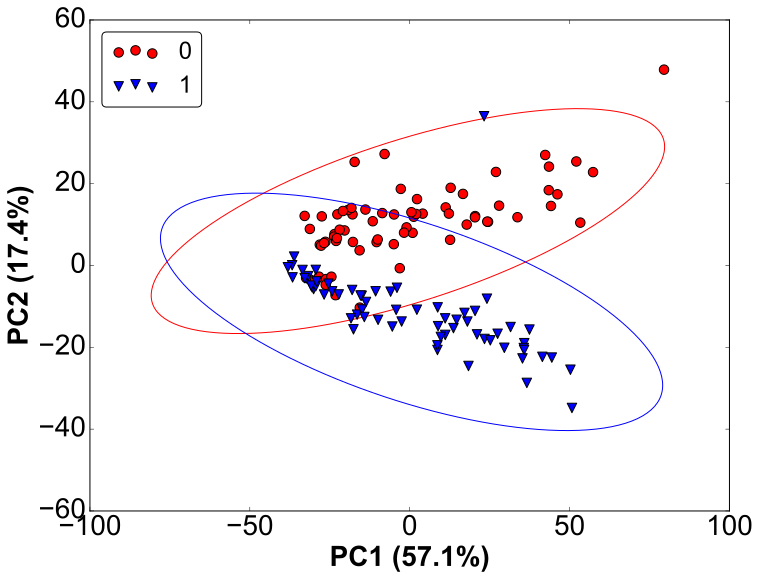

In [6]:
pca = CalcPCA()
pca.fit(X, y)
fig = pca.plotpc()

In [9]:
y2 = [
    f'{data_df.loc[i, "label"]}-{data_df.loc[i, "group"]}'
    for i in range(data_df.shape[0])
]

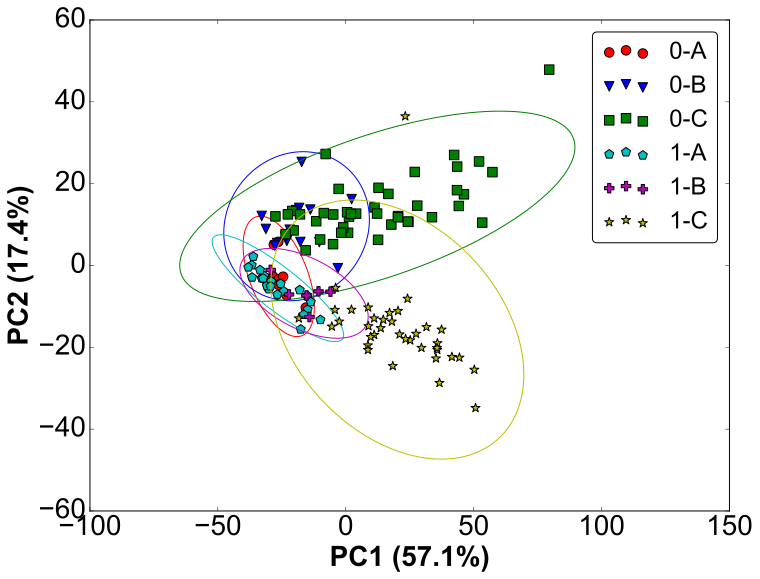

In [14]:
pca = CalcPCA()
pca.fit(X, y2)
fig = pca.plotpc()
fig.savefig(f"out/enose kakao_pca diff-ori_{tanggal}.svg")

### LDA

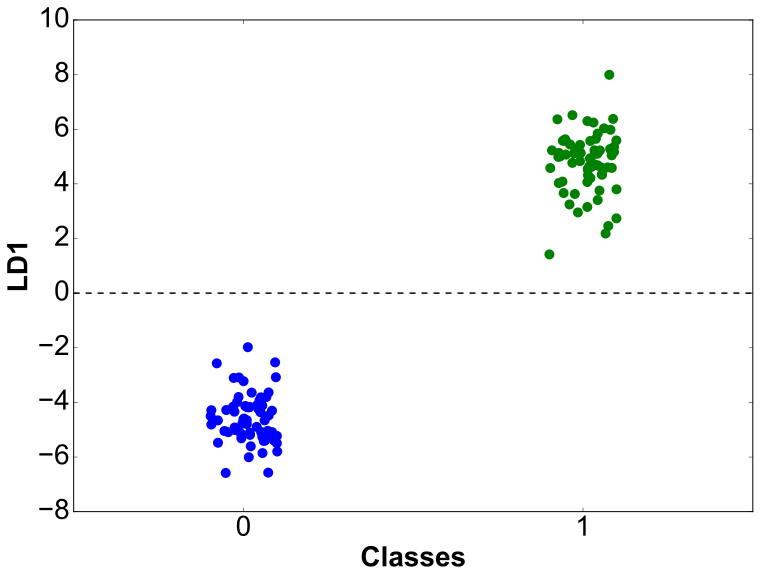

In [7]:
lda = CalcLDA()
lda.fit(X, y)
fig = lda.plotlda()

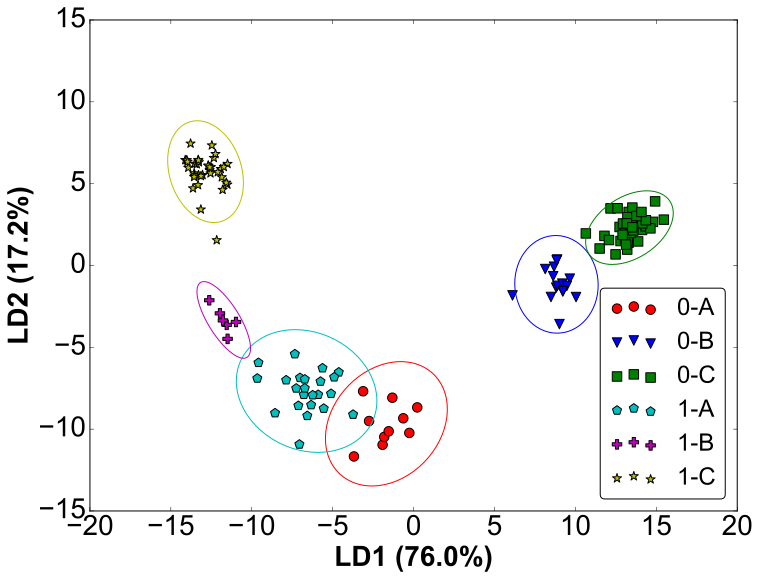

In [16]:
lda = CalcLDA()
lda.fit(X, y2)
fig = lda.plotlda()
fig.savefig(f"out/enose kakao_lda diff-ori_{tanggal}.svg")

### Validation

In [8]:
model = make_pipeline(MinMaxScaler(), LinearDiscriminantAnalysis())
score = cross_val_predict(model, X, y)
print(classification_report(y, score))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85        69
           1       0.85      0.83      0.84        66

    accuracy                           0.84       135
   macro avg       0.84      0.84      0.84       135
weighted avg       0.84      0.84      0.84       135



In [2]:
data_df = pd.read_parquet("data/data_diff_for_encoding.parquet")
idx = data_df.group.isin(['A'])
data = data_df[-idx].reset_index(drop=True)


X = data.values[:, :-3]
y = data.label.values

model = make_pipeline(MinMaxScaler(), LinearDiscriminantAnalysis())
score = cross_val_predict(model, X, y)
print(classification_report(y, score))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        59
           1       1.00      0.98      0.99        43

    accuracy                           0.99       102
   macro avg       0.99      0.99      0.99       102
weighted avg       0.99      0.99      0.99       102

